### 1. LOADING FILES

In [1]:
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score,confusion_matrix

In [111]:
lista_modelos=['DTC','RND','BAG','ADA','GBCT','LOGREG','KNN']

In [4]:
train=pd.read_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\df_train.csv',sep=',')
test=pd.read_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\df_test.csv',sep=',')
X_test=test[['Código Distrito Centro','Age_range_code','Nationality_code','Sex_code']]
X_train=train[['Código Distrito Centro','Age_range_code','Nationality_code','Sex_code']]
y_test=test['Código Tipo Supuesto Urgente']
y_train=train['Código Tipo Supuesto Urgente']

In [6]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(9477, 5)
(28429, 5)
(9477,)
(28429,)


In [5]:
def load_files(file):
    '''
    Cargar modelos con formato binario en un notebook o fichero python
    '''
    os.chdir('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\model')
    model = pickle.load( open( file, "rb" ) )
    return model


Aqui vamos a cargar los modelos para pasar los test

In [6]:
ADA = load_files('ADA220909190844.pickle')
BAG = load_files('BAG220909190839.pickle')
DTC = load_files('DTC220909190809.pickle')
RND=load_files('RND220909190829.pickle')

### 2. CALCULATING ERROR IN EACH MODEL

In [7]:
def error_modelo(model, X_test, y_test):
    '''
    Dejamos grabada cada uno de los parámetros de cada modelo y hacemos su representación
    '''
    y_pred = model.predict(X_test)
    f1_model=f1_score(y_test, y_pred,average='micro')
#    acc_model=accuracy_score(y_test, y_pred)
    precision_model=precision_score(y_test, y_pred,average='micro')
    recall_model=recall_score(y_test, y_pred,average='micro')
#    roc_auc_model=roc_auc_score(y_test, model.predict_proba(X_test),multi_class='ovr')
    conf_model=confusion_matrix(y_test, y_pred, normalize='true')
#    print('Accuracy', acc_model)
    print('F1', f1_model)
    print('Precision', precision_model)
    print('Recall', recall_model)
    print('-'*30)
#    print('ROC', roc_auc_model)

    plt.figure(figsize=(10,10))
    sns.heatmap(conf_model, annot=True)
    return precision_model, recall_model

def errores_modelos(lista_modelos:list): 
    '''
    Usamos una lista de los modelos entrenados para sacar sus metricas juntas y poder hacer asi una evaluación completa de todas
    '''            
    for model in lista_modelos:
        error_modelo(model) 


F1 0.7598639455782314
Precision 0.7598639455782313
Recall 0.7598639455782313
------------------------------


(0.7598639455782313, 0.7598639455782313)

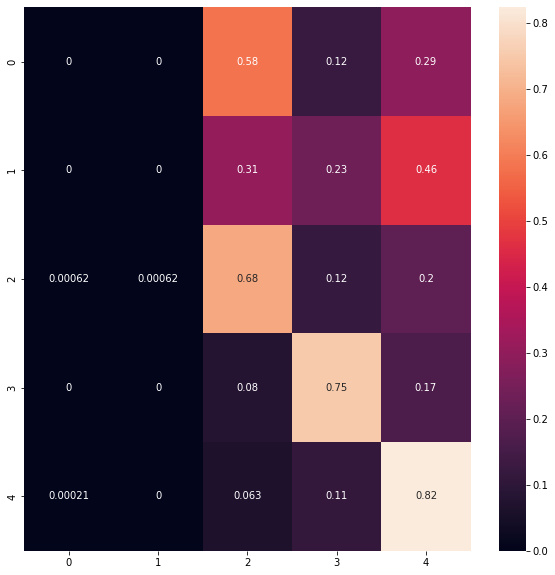

In [8]:
error_modelo(ADA, X_test, y_test)                 # De este modo, consigo sacar las variables que he generado dentro de la función

F1 0.7624716553287982
Precision 0.7624716553287982
Recall 0.7624716553287982
------------------------------


(0.7624716553287982, 0.7624716553287982)

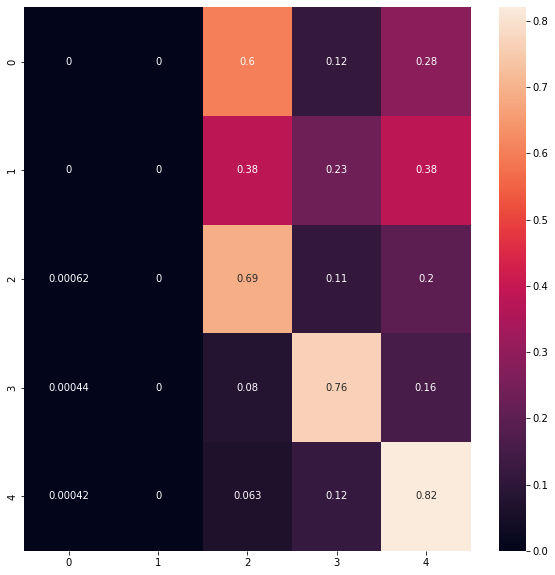

In [9]:
error_modelo(BAG, X_test, y_test)

F1 0.7605442176870748
Precision 0.7605442176870748
Recall 0.7605442176870748
------------------------------


(0.7605442176870748, 0.7605442176870748)

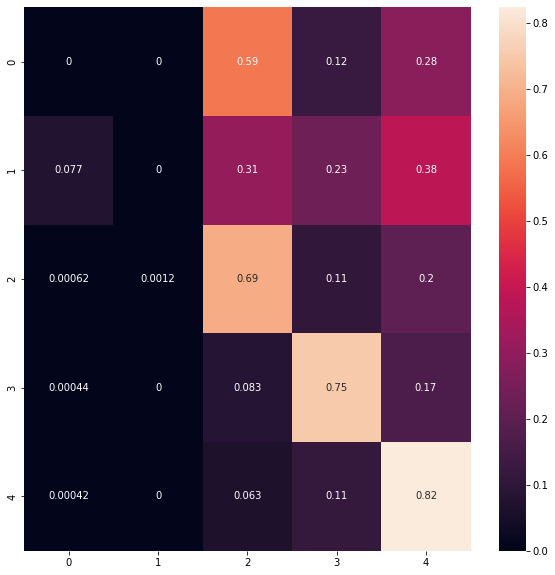

In [10]:
error_modelo(DTC, X_test, y_test)

F1 0.7605442176870748
Precision 0.7605442176870748
Recall 0.7605442176870748
------------------------------


(0.7605442176870748, 0.7605442176870748)

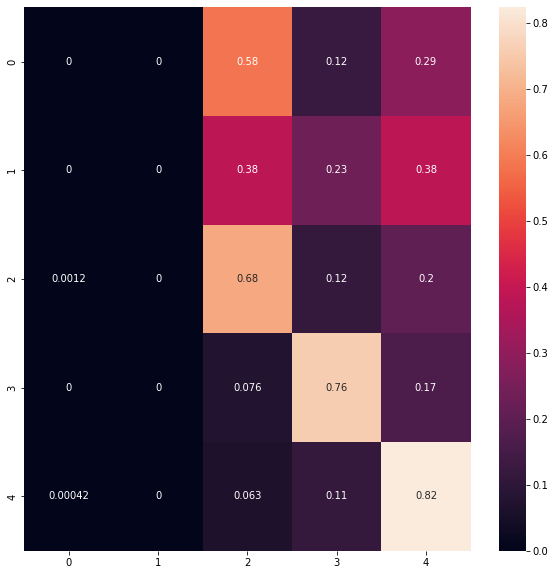

In [11]:
error_modelo(RND, X_test, y_test)

F1 0.7737680700643663
Precision 0.7737680700643663
Recall 0.7737680700643663
------------------------------


(0.7737680700643663, 0.7737680700643663)

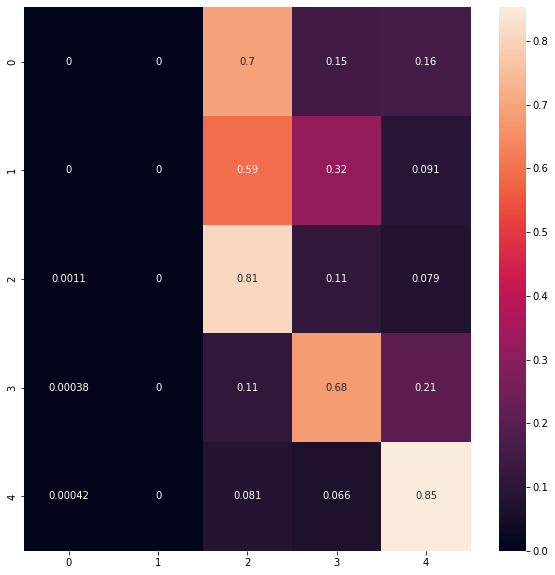

In [23]:
error_modelo(GBCT, X_test, y_test)

c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


F1 0.35549224438113325
Precision 0.35549224438113325
Recall 0.35549224438113325
------------------------------


(0.35549224438113325, 0.35549224438113325)

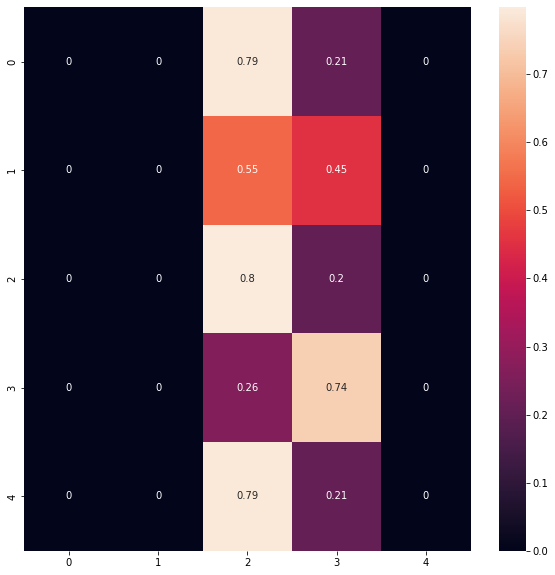

In [24]:
error_modelo(KNN, X_test, y_test)

F1 0.6996939959902923
Precision 0.6996939959902923
Recall 0.6996939959902923
------------------------------


(0.6996939959902923, 0.6996939959902923)

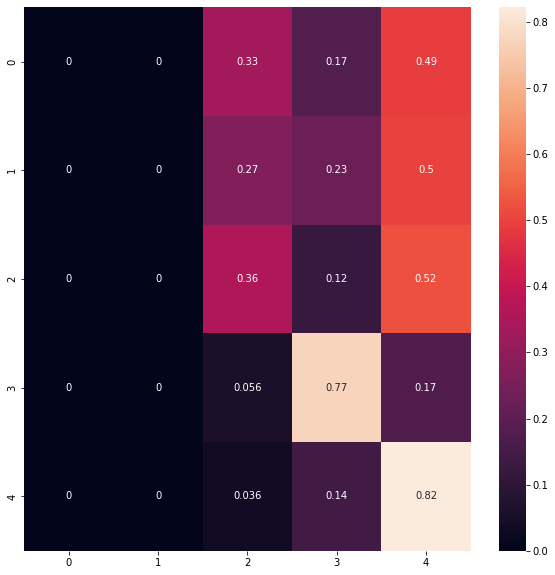

In [25]:
error_modelo(LOGREG, X_test, y_test)

Viendo estos datos desechamos los modelos de *REGRESION LOGÍSTICA* y de *K NEAREST NEIGHBORS*, ya que sus métricas están alejadas del resto.

### 3. LOOKING FOR THE BEST MODEL

**ADA**

In [14]:
ada_params = {
    'n_estimators': np.arange(1,200,50),                                # hacerlo o mano y ver si consigo mejores resultados
    'learning_rate': np.arange(0.01,0.1,0.02),
    'algorithm': ['SAMME','SAMME.R']   
}

GS_ADA = GridSearchCV(estimator = ADA,
                  param_grid = ada_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 5,
                  scoring='f1_micro',
#                  error_score='raise'
                    )

GS_ADA.fit(X_train, y_train)
print(GS_ADA.best_estimator_)
print(GS_ADA.best_score_)
print(GS_ADA.best_params_)
#pickle.dump(GS_ADA.best_estimator_,open('GS_ADA','wb'))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         random_state=20),
                   learning_rate=0.06999999999999999, n_estimators=51,
                   random_state=20)
0.7585411942554801
{'algorithm': 'SAMME.R', 'learning_rate': 0.06999999999999999, 'n_estimators': 51}


Según estos datos habría que realizar un nuevo GS modificando el parámetro *learning_rate* disminuyendo el rango.

F1 0.7605442176870748
Precision 0.7605442176870748
Recall 0.7605442176870748
------------------------------


(0.7605442176870748, 0.7605442176870748)

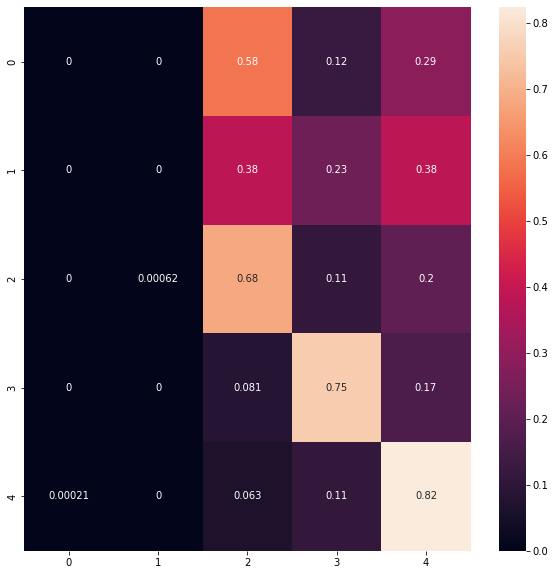

In [15]:
error_modelo(GS_ADA.best_estimator_, X_test, y_test)

**BAG**

In [16]:
bag_params = {
    'bootstrap': [True,False],                              # hacerlo o mano y ver si consigo mejores resultados
    'warm_start': [True,False],
    'max_features': np.arange(3,5,1),
    'max_samples': np.arange(125,175,25),
    'n_estimators': np.arange(125,175,25)
}

GS_BAG = GridSearchCV(estimator = BAG,
                  param_grid = bag_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 5,
                  scoring='f1_micro')

GS_BAG.fit(X_train, y_train)
print(GS_BAG.best_estimator_)
print(GS_BAG.best_score_)
print(GS_BAG.best_params_)
#pickle.dump(GS_BAG.best_estimator_,open('GS_BAG','wb'))

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=20),
                  max_features=4, max_samples=150, n_estimators=125,
                  random_state=20, warm_start=True)
0.7592592592592592
{'bootstrap': True, 'max_features': 4, 'max_samples': 150, 'n_estimators': 125, 'warm_start': True}


Estos parámetros son válidos como valores de optimización.

Se podría mejorar acotando más aún los mismos.

In [23]:
GS_BAG.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=20),
                  bootstrap=False, max_features=4, max_samples=151,
                  n_estimators=151, random_state=20, warm_start=True)

F1 0.7626984126984128
Precision 0.7626984126984127
Recall 0.7626984126984127
------------------------------


(0.7626984126984127, 0.7626984126984127)

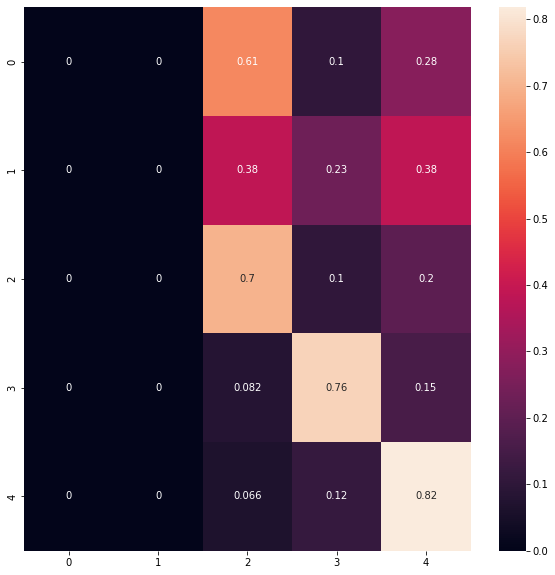

In [17]:
error_modelo(GS_BAG.best_estimator_, X_test, y_test)

**DTC**

In [18]:
DTC_params = {
#    'max_leaf_nodes': np.arange(1,50,5),                    # hacerlo o mano y ver si consigo mejores resultados
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(1,5,1),
    'max_features': np.arange(3,5,1),
    'min_samples_leaf': np.arange(0.05,0.15,0.05),
    'min_samples_split': np.arange(3,7,1)
}

GS_DTC = GridSearchCV(estimator = DTC,
                  param_grid = DTC_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 3,
                  scoring='f1_micro')

GS_DTC.fit(X_train, y_train)
print(GS_DTC.best_estimator_)
print(GS_DTC.best_score_)
print(GS_DTC.best_params_)
#pickle.dump(GS_DTC.best_estimator_,open('GS_DTC','wb'))

DecisionTreeClassifier(max_depth=3, max_features=3, min_samples_leaf=0.05,
                       min_samples_split=3, random_state=20)
0.7401360544217687
{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 0.05, 'min_samples_split': 3}


F1 0.7417233560090702
Precision 0.7417233560090702
Recall 0.7417233560090702
------------------------------


(0.7417233560090702, 0.7417233560090702)

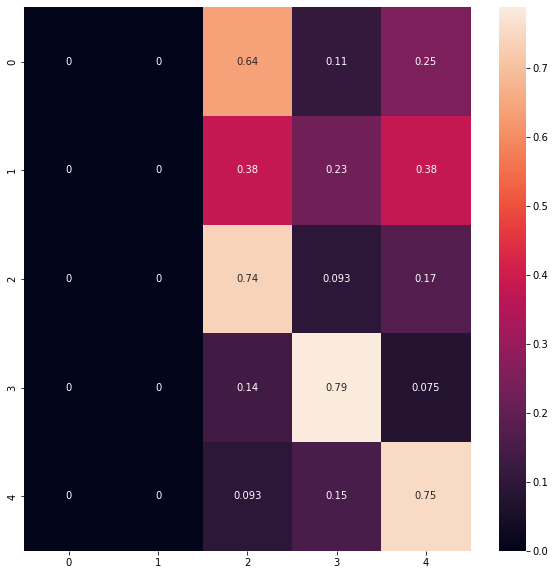

In [19]:
error_modelo(GS_DTC.best_estimator_, X_test, y_test)

**RND**

In [22]:
random_forest_params = {                            # pendiente de volver a realizarlo
    'max_leaf_nodes': [5,6,7],
#    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4],
    'max_features': [3,4],
#    'min_samples_leaf': [0.05,0.1,0.15],
#    'bootstrap': [True,False],
#    'warm_start': [True,False],
    'min_samples_split': [2 ,5,15,20]
}

GS_RND = GridSearchCV(estimator = RND,
                  param_grid = random_forest_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 3,
#                  error_score='raise',
                  scoring='f1_micro')

GS_RND.fit(X_train, y_train)
print(GS_RND.best_estimator_)
print(GS_RND.best_score_)
print(GS_RND.best_params_)
pickle.dump(GS_RND.best_estimator_,open('GS_RND','wb'))

RandomForestClassifier(max_depth=4, max_features=3, max_leaf_nodes=7,
                       random_state=20)
0.7540060468631897
{'max_depth': 4, 'max_features': 3, 'max_leaf_nodes': 7, 'min_samples_split': 2}


F1 0.7600907029478459
Precision 0.7600907029478458
Recall 0.7600907029478458
------------------------------


(0.7600907029478458, 0.7600907029478458)

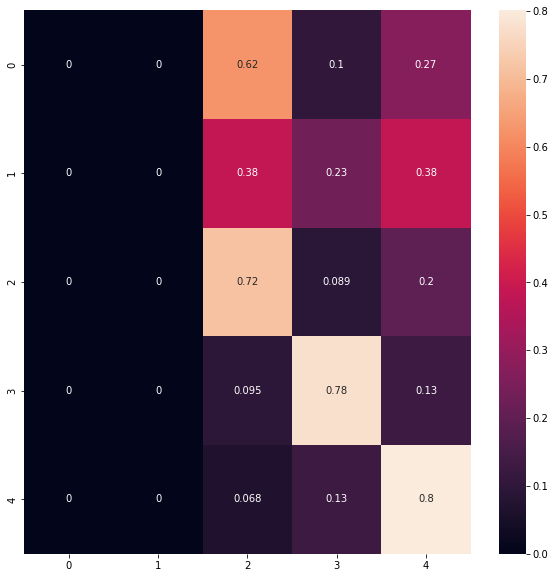

In [21]:
error_modelo(GS_RND.best_estimator_, X_test, y_test)

**GBCT**


QUEDA ESTE MODELO POR MEJORAR

In [24]:
GB_params = {                                                                       # He reducido cantiddad de valores para repetirlo y ver si lo hace 
#    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth': np.arange(1,11,5),
    'warm_start': [True, False],
    'max_features': np.arange(2,5,2),
    'learning_rate': np.arange(0.05,0.55,0.25),
    'min_samples_split': np.arange(5,30,10),
    'n_estimators': np.arange(100,200,50)
}

GS_GBCT = GridSearchCV(estimator = GBCT,
                  param_grid = GB_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  error_score='raise',
                  cv = 3,
                  scoring='f1_micro')

GS_GBCT.fit(X_train, y_train)
print(GS_GBCT.best_estimator_)
print(GS_GBCT.best_score_)
print(GS_GBCT.best_params_)
pickle.dump(GS_GBCT.best_estimator_,open('GS_GBCT','wb'))

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=2,
                           min_samples_split=25, random_state=20,
                           warm_start=True)
0.7747371094866261
{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 2, 'min_samples_split': 25, 'n_estimators': 100, 'warm_start': True}


F1 0.7726073651999577
Precision 0.7726073651999578
Recall 0.7726073651999578
------------------------------


(0.7726073651999578, 0.7726073651999578)

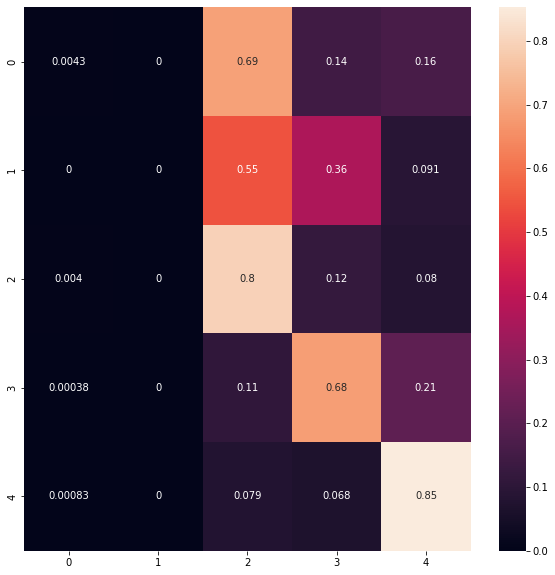

In [25]:
error_modelo(GS_GBCT.best_estimator_, X_test, y_test)

Salvo el modelo **ADA Boost** ninguno de los modelos mejora con un *GridSearch*, es por ello que vamos a hacer un último intento de mejorar los modelos "a mano".